## Q1. Downloading the data

We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "Yellow Taxi Trip Records".

Download the data for January and February 2023.

Read the data for January. How many columns are there?

In [2]:
import pandas as pd

In [3]:
jan_data = pd.read_parquet("./data/yellow_tripdata_2023-01.parquet")

print(f"Jan data has {jan_data.shape[1]} columns")

Jan data has 19 columns


## Q2. Computing duration

Now let's compute the duration variable. It should contain the duration of a ride in minutes.

In [4]:
import datetime as datetime

In [5]:
jan_data["duration"] = jan_data["tpep_dropoff_datetime"] - jan_data["tpep_pickup_datetime"]
duration_std_dev: datetime.timedelta = jan_data["duration"].std()

print(f"Standard deviation of rides is {'{0:.2f}'.format(duration_std_dev.total_seconds() / 60)} minutes")

Standard deviation of rides is 42.59 minutes


## Q3. Dropping outliers

Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

In [6]:
import matplotlib.pyplot as plt

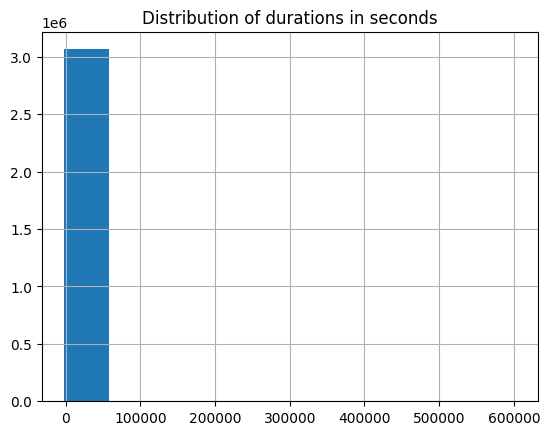

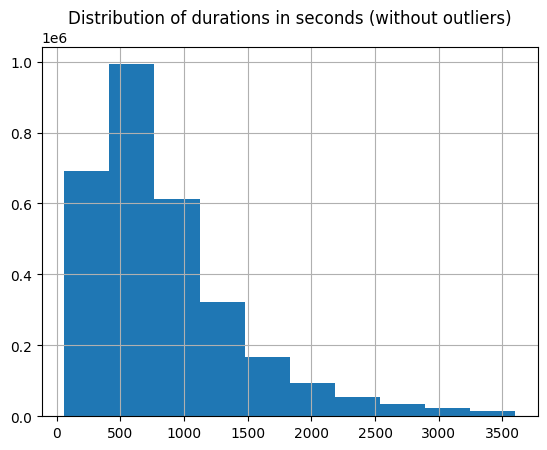

98% of rows remain in the dataset


In [7]:
jan_data["duration_seconds"] = jan_data["duration"].dt.total_seconds()
row_count = jan_data.shape[0]

jan_data["duration_seconds"].hist()
plt.title("Distribution of durations in seconds")
plt.show()

jan_data_filtered = jan_data[jan_data["duration_seconds"].between(60, 3600, inclusive='both')]
filtered_row_count = jan_data_filtered.shape[0]

plt_2 = jan_data_filtered["duration_seconds"].hist()
plt.title("Distribution of durations in seconds (without outliers)")
plt.show()

print(f"{round(100 * filtered_row_count / row_count)}% of rows remain in the dataset")


## Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

* Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
* Fit a dictionary vectorizer
* Get a feature matrix from it

What's the dimensionality of this matrix (number of columns)?

In [ ]:
from sklearn.feature_extraction import DictVectorizer

features = pd.DataFrame()
features["PULocationID"] = jan_data_filtered["PULocationID"].apply(lambda x: str(x))
features["DOLocationID"] = jan_data_filtered["DOLocationID"].apply(lambda x: str(x))
as_dict = features.to_dict(orient="records")

vectorizer = DictVectorizer(sparse=True)
feature_matrix = vectorizer.fit_transform(as_dict)

: 

In [ ]:
print(f"The feature matrix has {feature_matrix.shape[1] - 1} columns")

The feature matrix has 516 columns


## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model. 

* Train a plain linear regression model with default parameters 
* Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
X = feature_matrix[:, :-1] # All but last column (duration)
y = feature_matrix[:, -1] # Only last column (duration)

model = LinearRegression()
model.fit(X.toarray(), y.toarray())

: 